# Advanced ML: Classification : Decision Trees
<img src="assets/groot.gif" width="1000">

## Key Concepts:

+ __Root Node__: Represents the starting node. This is further divided into two or more homogeneous sets.
+ __Splitting__: Process of dividing a node into two or more sub-nodes.
+ __Decision Node__: A sub-node that splits into further sub-nodes.
+ __Leaf/ Terminal Node__: Nodes which do not split any further.
+ __Pruning__: Process of removal of sub-nodes of a decision node. 

### Splitting Criteria

__Gini Index__
If two items are selected from a population at random then they must be of same class and probability for this is 1 (if population is pure).

+ Useful with categorical target variables.
+ Performs on Binary splits
+ Higher the value of Gini higher the homogeneity.

Steps to Calculate Gini :
+ Calculate Gini for sub-nodes, using formula sum of square of probability for success and failure (p²+q²).
+ Calculate Gini for split using weighted Gini score of each node of that split

---

__Chi-Square__
It is used to find the statistical significance of the differences between sub-nodes and parent node. It is measured as _sum of squares of standardized differences between observed and expected frequencies of target variable_.
+ Useful with categorical target variables.
+ Can perform two or more splits.
+ Higher the value of Chi-Square higher the statistical significance of differences between sub-node and Parent node.

Chi-Square of each node is calculated as:

$\chi^2 = \sqrt{(\frac{(Actual - Expected)^2}{Expected})}$


Steps to Calculate Chi-square for a split:
+ Calculate Chi-square for individual node by calculating the deviation for Success and Failure both
+ Calculated Chi-square of Split using Sum of all Chi-square of success and Failure of each node of the split

---

__Information Gain__

Entropy is defined as a measure of degree of disorganization in a system. If a sample is completely homogeneous, then the entropy is zero and if the sample is an equally distributed (50% – 50%), it has an entropy of one.

Entropy can be calculated using formula:

$Entropy = -plog_2 p - qlog_2 q$

Where $p and q$ are probabilities of success and failure respectively for a node. Entropy is also used with categorical target variable. It chooses the split which has lowest entropy compared to parent node and other splits. The lesser the entropy, the better it is.

Steps to calculate entropy for a split:

+ Calculate entropy of parent node
+ Calculate entropy of each individual node of split and calculate weighted average of all sub-nodes available in split.

### Key Hyperparameters

+ Minimum samples for a node split
+ Minimum samples for a terminal node (leaf)
+ Maximum depth of tree (vertical depth)
+ Maximum number of terminal nodes

### Advantages of Decision Trees

+ Ease of Understanding
+ Robust to Outliers and Scaling
+ Works with both numerical and categorical variables


### Disadvantages of Decision Trees

+ Overfitting

## Hands-on

### Prerequisites

Install pydotplus in your own virtual environment

```!pip install pydotplus```

## Question 1

* Import the data and examine the features (skip as done as part of SVM exercise).
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded. 

In [5]:
from __future__ import print_function
import os
data_path = ['data']

In [6]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')

### Encode Target Variable

In [8]:
data['color'] = data.color.replace('white',0).replace('red',1).astype(np.int)

## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.

In [9]:
# All data columns except for color
feature_cols = [x for x in data.columns if x not in 'color']

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

### Check Distribution

In [11]:
y_train.value_counts(normalize=True).sort_index()

0    0.753866
1    0.246134
Name: color, dtype: float64

In [12]:
y_test.value_counts(normalize=True).sort_index()

0    0.754
1    0.246
Name: color, dtype: float64

## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [15]:
print("Number of nodes= {}\nMaximum Depth= {}".format(dt.tree_.node_count, dt.tree_.max_depth))

Number of nodes= 171
Maximum Depth= 22


### Model Evaluation

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [17]:
# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


## Question 4

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  cv=3,
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [21]:
print("Number of nodes= {}\nMaximum Depth= {}".format(GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth))

Number of nodes= 99
Maximum Depth= 7


### Model Evaluation

In [22]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

In [23]:
train_test_gr_error

,train,test
accuracy,0.995816,0.989000
precision,0.998501,0.983539
recall,0.984479,0.971545
f1,0.991440,0.977505


## Question 5 

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

In [24]:
from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz

try:
    import pydotplus
    pydotplus_installed = True
    
except:
    print('PyDotPlus must be installed to execute the remainder of the cells associated with this question.')
    print('Please see the instructions for this question for details.')
    pydotplus_installed = False

### Default Decision Tree

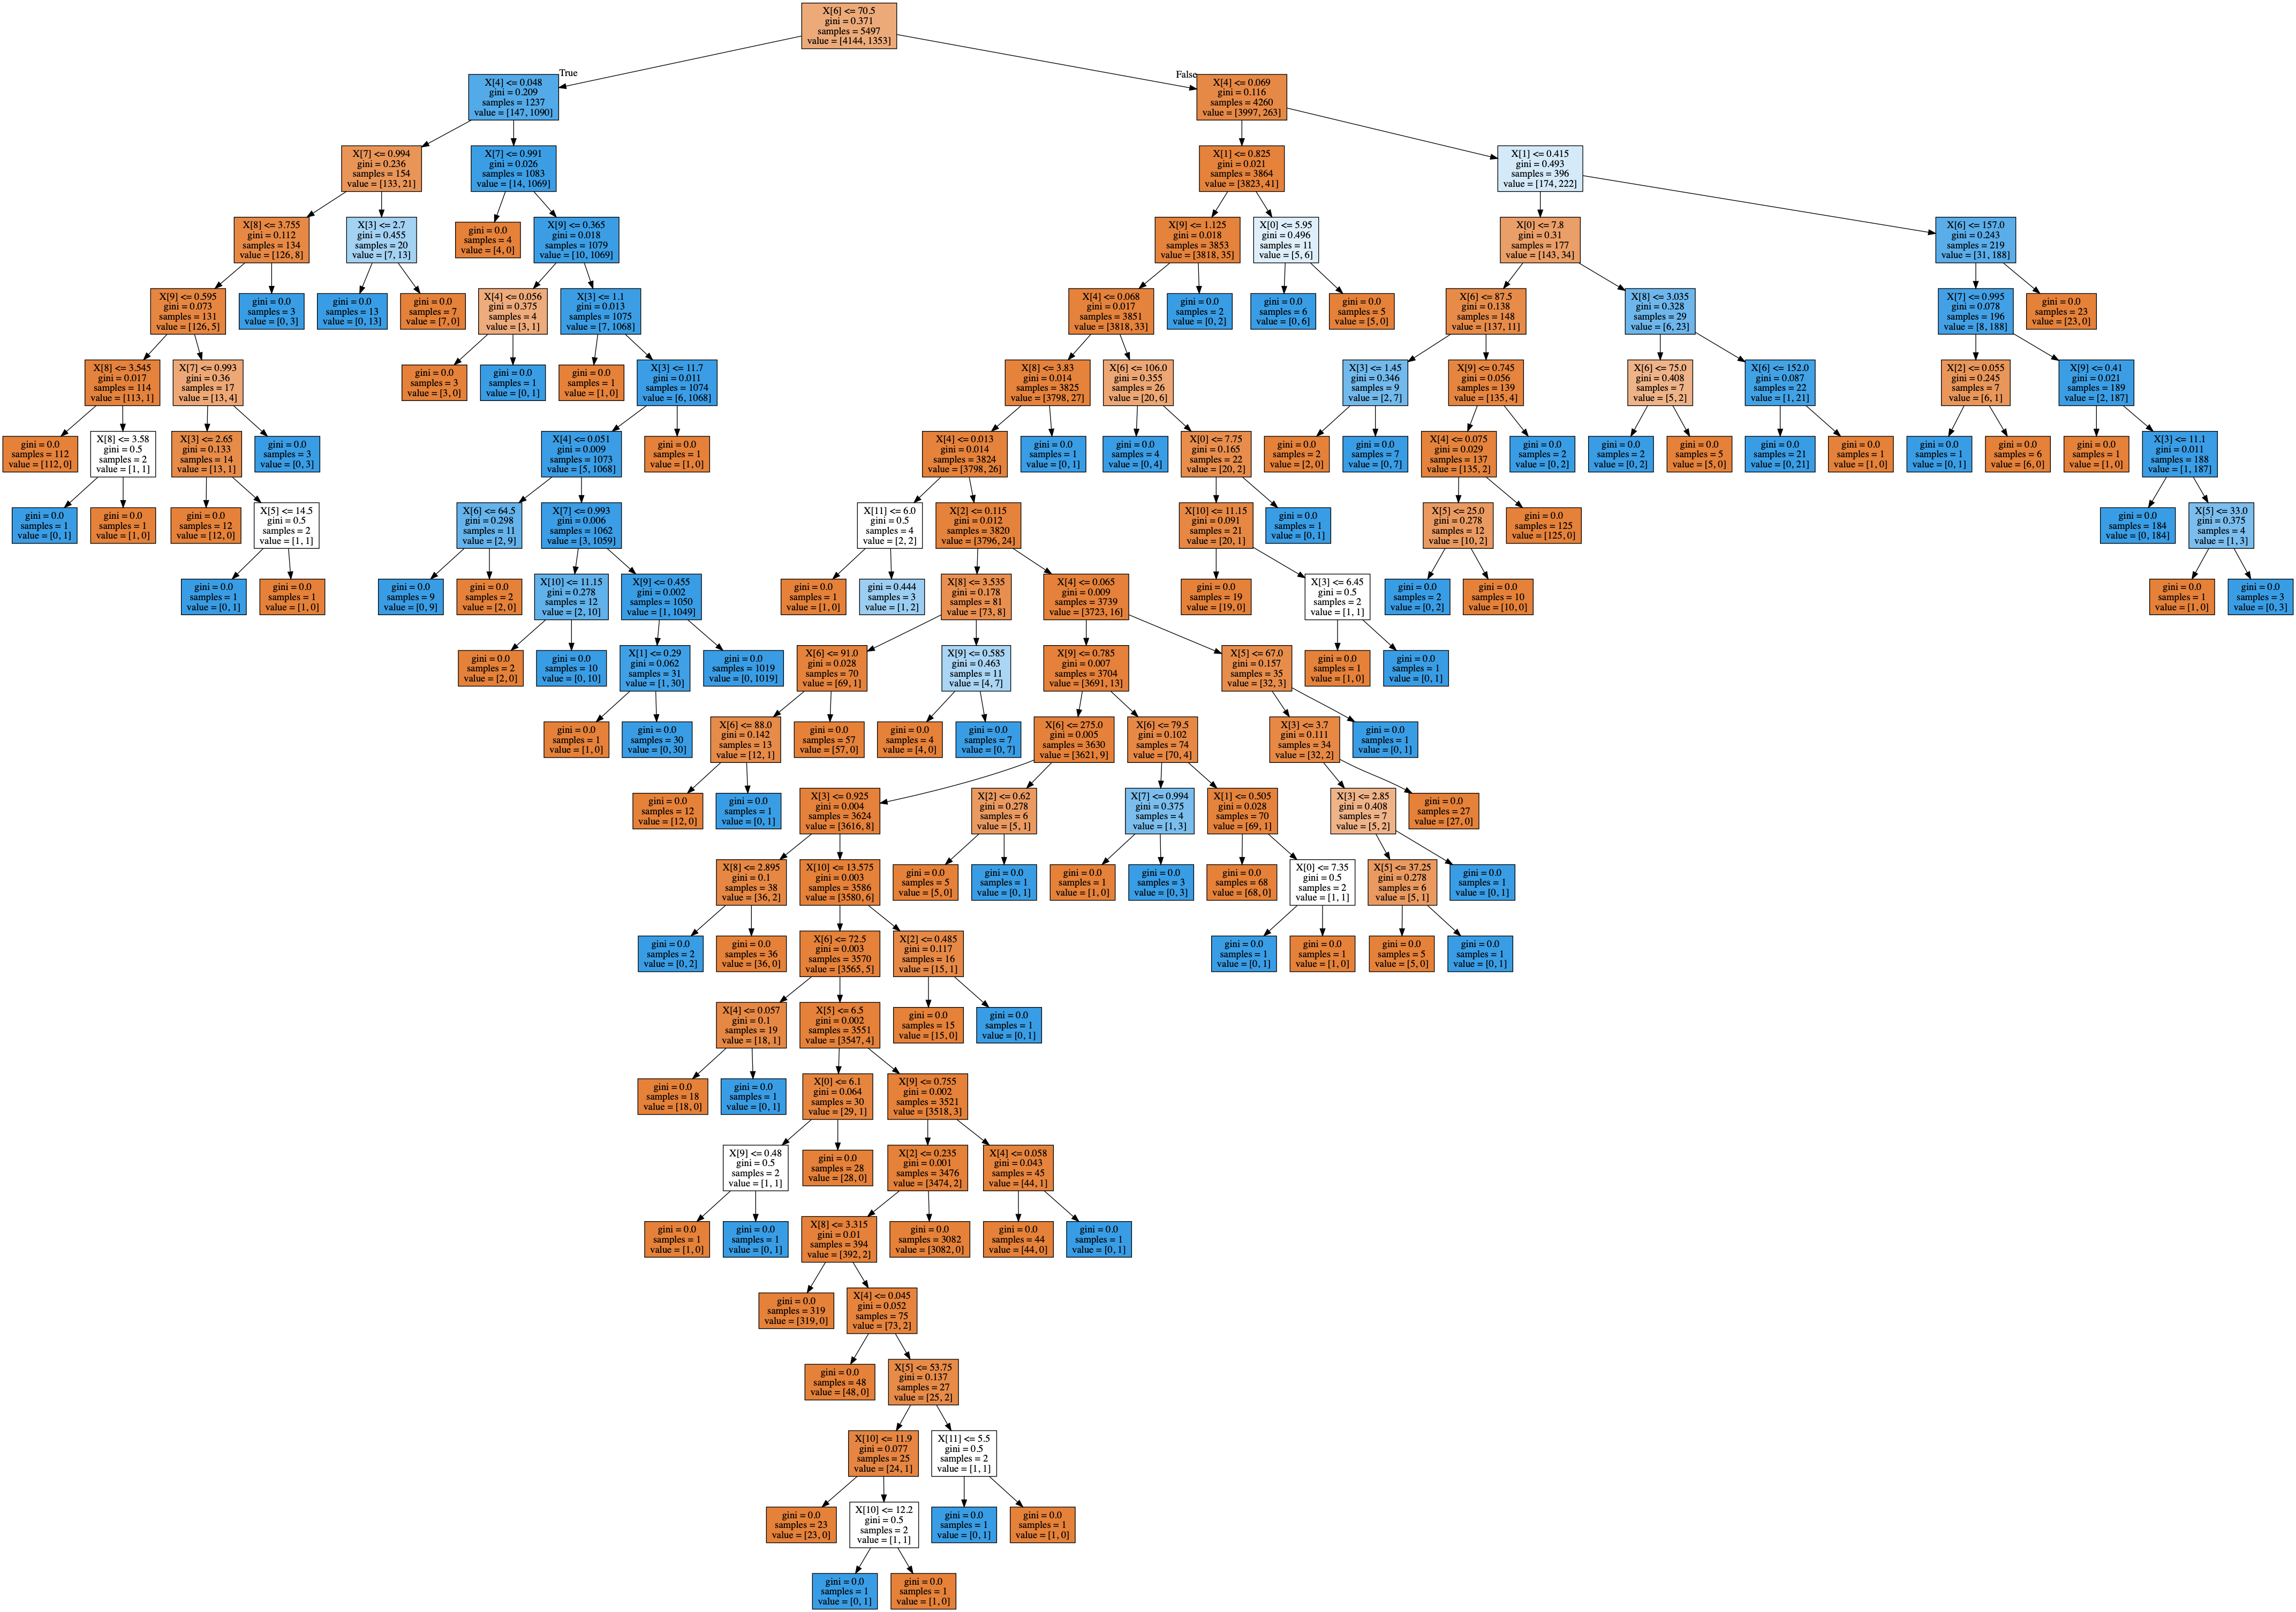

In [25]:
if pydotplus_installed:
    
    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(dt, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(graph)
    # View the tree image
    filename = 'wine_tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')

### Grid Searched : Best Estimator (shallower tree)

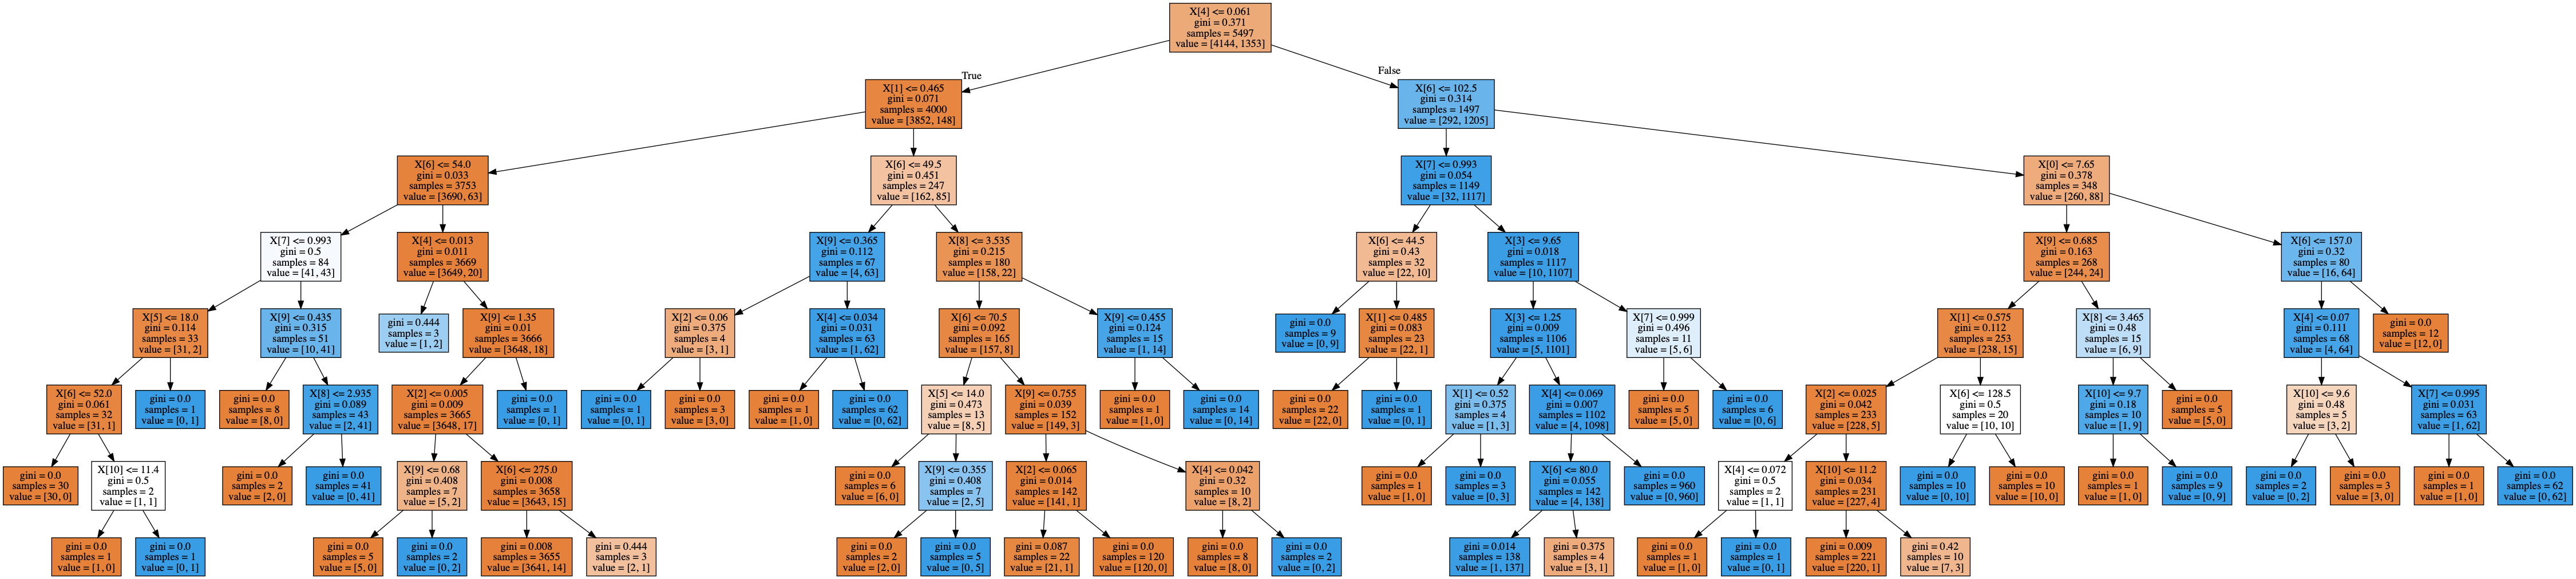

In [26]:
if pydotplus_installed:
    
    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'wine_tree_prune_grid.png'
    graph.write_png(filename)
    img = Image(filename=filename) 
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')